# Lab Strain Bitomes

## Setup

### Import Required Packages

In [2]:
import ast
import os
from pathlib import Path
import re
import sys

from Bio.SeqUtils import GC
from Bio.SeqFeature import FeatureLocation
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

BITOME_KB_PATH = Path('..', 'bitome-kb')
sys.path.append(BITOME_KB_PATH.absolute().as_posix())
from bitome.core import Bitome

# the Vienna RNA python package is automatically installed in a particular directory
# ensure that that directory is on Python's path
VIENNA_DIR = '/usr/local/lib/python3.7/site-packages'
sys.path.append(VIENNA_DIR)
import RNA

### Set Global Variables

In [17]:
DATA_PATH = Path('..', 'data')
GENOME_DIR = Path(DATA_PATH, 'e_coli_genomes')
PROKKA_DIR = Path(GENOME_DIR, 'prokka')
NCBI_DIR = Path(GENOME_DIR, 'ncbi')

### Load Bitome KBs for Each Genome

In [18]:
e_coli_bitomes_prokka = []
for filename in os.listdir(PROKKA_DIR):
    if '.pkl' in filename:
        new_bitome = Bitome.init_from_file(Path(PROKKA_DIR, filename))
        e_coli_bitomes.append(new_bitome)

In [19]:
e_coli_bitomes_ncbi = []
for filename in os.listdir(NCBI_DIR):
    if '.gb' in filename:
        new_bitome = Bitome(genbank_file_path=Path(NCBI_DIR, filename))
        new_bitome.load_data()
        new_bitome.save(TODO)
        e_coli_bitomes_ncbi.append(new_bitome)

ValueError: Z1898: sequence should have multiple of 3 length if gene is coding

In [10]:
genome_info_df = pd.read_excel(Path(GENOME_DIR, 'lab_strains.xlsx'))
genome_info_df = genome_info_df.set_index('id')

## Basic Analysis

### Sequence Lengths

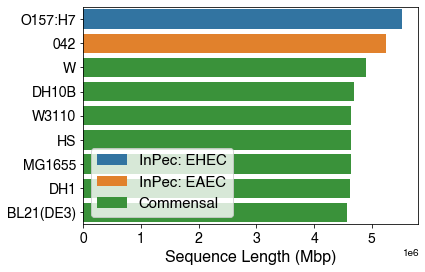

In [11]:
genome_info_df['seq_length'] = None

for bitome in e_coli_bitomes:
    genome_info_df.loc[bitome.genbank_id[:-2], 'seq_length'] = len(bitome.sequence)

_, ax = plt.subplots()

sns.barplot(
    x='seq_length',
    y='short_name',
    hue='pathotype',
    dodge=False,
    data=genome_info_df.sort_values(by='seq_length', ascending=False),
    orient='h',
    ax=ax
)

ax.set_xlabel('Sequence Length (Mbp)', fontsize=16)
ax.set_ylabel('')
ax.tick_params(axis='both', labelsize=14)

ax.legend(loc='lower left', fontsize=15)

plt.show()

### Gene Counts

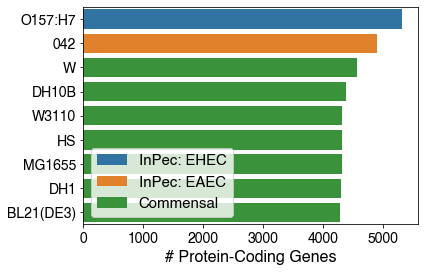

In [12]:
genome_info_df['n_genes'] = None
for bitome in e_coli_bitomes:
    genome_info_df.loc[bitome.genbank_id[:-2], 'n_genes'] = len(bitome.coding_genes)

_, ax = plt.subplots()

sns.barplot(
    x='n_genes',
    y='short_name',
    hue='pathotype',
    dodge=False,
    data=genome_info_df.sort_values(by='n_genes', ascending=False),
    orient='h',
    ax=ax
)

ax.set_xlabel('# Protein-Coding Genes', fontsize=16)
ax.set_ylabel('')
ax.tick_params(axis='both', labelsize=14)

ax.legend(loc='lower left', fontsize=15)

plt.show()

### Gene Lengths

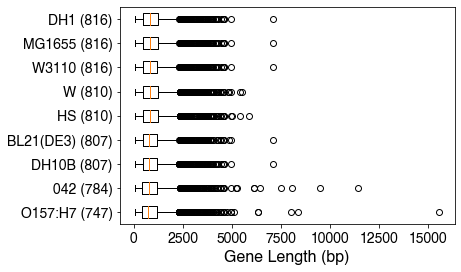

In [13]:
gene_lengths = [[len(g.sequence) for g in bitome.genes] for bitome in e_coli_bitomes]
short_names = [
    genome_info_df.loc[bitome.genbank_id[:-2], 'short_name']
    for bitome in e_coli_bitomes
]
medians = [np.median(gl) for gl in gene_lengths]

sorted_medians, sorted_lengths, sorted_names = zip(*sorted(
    zip(medians, gene_lengths, short_names),
    key=lambda tup: tup[0]
))

labels = [f'{name} ({int(med)})' for med, name in zip(sorted_medians, sorted_names)]

_, ax = plt.subplots()
plt.boxplot(sorted_lengths, vert=False, labels=labels)
ax.set_xlabel('Gene Length (bp)', fontsize=16)
ax.tick_params(axis='both', labelsize=14)

plt.show()

### GC Content

#### Whole Genome

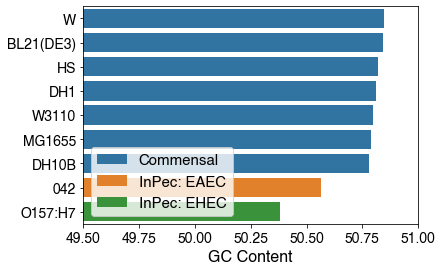

In [14]:
genome_info_df['GC'] = None
for bitome in e_coli_bitomes:
    genome_info_df.loc[bitome.genbank_id[:-2], 'GC'] = GC(bitome.sequence)

_, ax = plt.subplots()

sns.barplot(
    x='GC',
    y='short_name',
    hue='pathotype',
    dodge=False,
    data=genome_info_df.sort_values(by='GC', ascending=False),
    orient='h',
    ax=ax
)

ax.set_xlabel('GC Content', fontsize=16)
ax.set_ylabel('')
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(49.5, 51)

ax.legend(loc='lower left', fontsize=15)

plt.show()

#### Gene by Gene

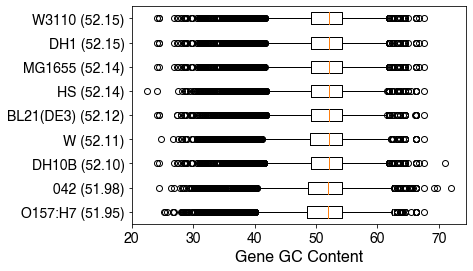

In [15]:
gene_gcs = [[GC(g.sequence) for g in bitome.genes] for bitome in e_coli_bitomes]
short_names = [
    genome_info_df.loc[bitome.genbank_id[:-2], 'short_name']
    for bitome in e_coli_bitomes
]
medians = [np.median(gc) for gc in gene_gcs]

sorted_medians, sorted_gcs, sorted_names = zip(*sorted(
    zip(medians, gene_gcs, short_names),
    key=lambda tup: tup[0]
))

labels = [f'{name} ({med:.2f})' for med, name in zip(sorted_medians, sorted_names)]

_, ax = plt.subplots()
plt.boxplot(sorted_gcs, vert=False, labels=labels)
ax.set_xlabel('Gene GC Content', fontsize=16)
ax.tick_params(axis='both', labelsize=14)

plt.show()

### Unique Genes

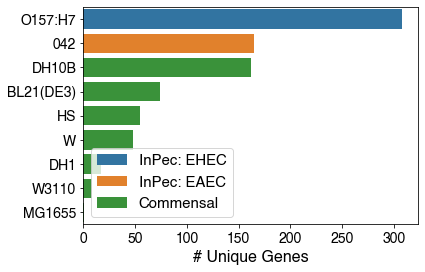

In [16]:
names_by_genomes = [set([g.name for g in b.coding_genes]) for b in e_coli_bitomes]

genome_info_df['unique_genes'] = None
for i, (name_set, bitome) in enumerate(zip(names_by_genomes, e_coli_bitomes)):
    names_by_genomes_copy = names_by_genomes.copy()
    names_by_genomes_copy.pop(i)
    union_other = set.union(*names_by_genomes_copy)
    genome_info_df.loc[bitome.genbank_id[:-2], 'unique_genes'] = len(name_set.difference(union_other))

_, ax = plt.subplots()

sns.barplot(
    x='unique_genes',
    y='short_name',
    hue='pathotype',
    dodge=False,
    data=genome_info_df.sort_values(by='unique_genes', ascending=False),
    orient='h',
    ax=ax
)

ax.set_xlabel('# Unique Genes', fontsize=16)
ax.set_ylabel('')
ax.tick_params(axis='both', labelsize=14)

ax.legend(loc='lower left', fontsize=15)

plt.show()


## NCBI/Prokka Comparison